Accuracy: 0.8913
Recall (Sensitivity): 0.9412
Specificity: 0.8621
Precision: 0.8000
F1 Score: 0.8649
AUC: 0.9249

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91        29
         1.0       0.80      0.94      0.86        17

    accuracy                           0.89        46
   macro avg       0.88      0.90      0.89        46
weighted avg       0.90      0.89      0.89        46


Confusion Matrix (Non-Normalized):
[[25  4]
 [ 1 16]]


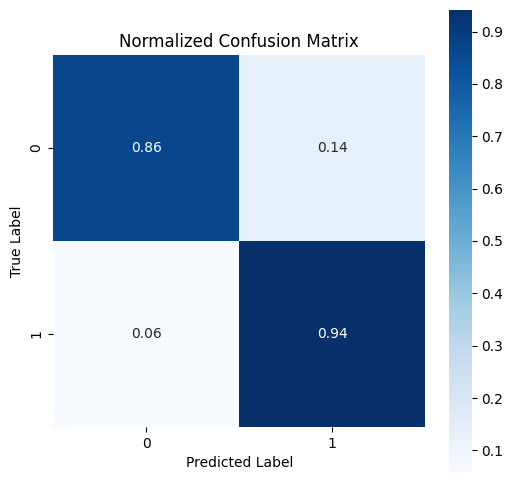


Bootstrapped Metrics with 95% Confidence Intervals:
Accuracy: 0.8897
95% CI: [0.8869, 0.8925]

Recall (Sensitivity): 0.9429
95% CI: [0.9393, 0.9464]

Specificity: 0.8596
95% CI: [0.8556, 0.8636]

Precision: 0.7948
95% CI: [0.7892, 0.8004]

F1 Score: 0.8590
95% CI: [0.8552, 0.8628]

AUC: 0.9256
95% CI: [0.9231, 0.9280]



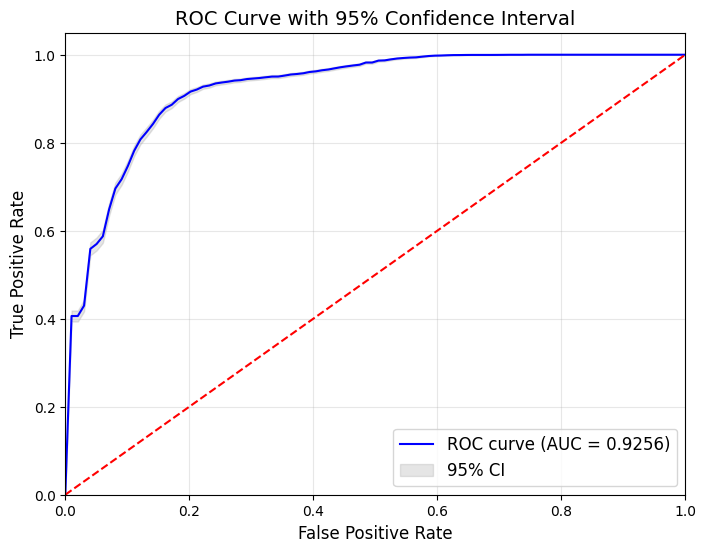

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report, 
)
from sklearn.utils import resample
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def process_csv(file_path, sequence_mode):
    df = pd.read_csv(file_path)
    df['probability'] = df['probability'].astype(float)

    if sequence_mode == 'mean':
        grouped_df = df.groupby('mri_id').agg({
            'probability': 'mean',
            'label': 'first'  # Assuming all labels for the same mri_id are the same
        }).reset_index()
    elif sequence_mode == 'median':
        grouped_df = df.groupby('mri_id').agg({
            'probability': 'median',
            'label': 'first'
        }).reset_index()
    elif sequence_mode == 'min':
        grouped_df = df.groupby('mri_id').agg({
            'probability': 'min',
            'label': 'first'
        }).reset_index()
    elif sequence_mode == 'max':
        grouped_df = df.groupby('mri_id').agg({
            'probability': 'max',
            'label': 'first'
        }).reset_index()
    elif sequence_mode == 'most_confident':
        df['distance_from_0.5'] = np.abs(df['probability'] - 0.5)
        grouped_df = df.loc[df.groupby('mri_id')['distance_from_0.5'].idxmax()]
    else:
        raise ValueError("Invalid sequence_mode")
    
    
    #print(f'Dataframe shape: {grouped_df.shape}')
    #print(grouped_df['mri_id'].value_counts())

    return grouped_df

def combine_views(csv_paths, sequence_mode, view_mode):
    processed_dfs = [process_csv(path, sequence_mode) for path in csv_paths]

    combined_df = processed_dfs[0]
    for i, df in enumerate(processed_dfs[1:], start=1):
        combined_df = pd.merge(combined_df, df, on='mri_id', suffixes=('', f'_view{i}'))

    probability_columns = [col for col in combined_df.columns if col.startswith('probability')]
    
    if view_mode == 'mean':
        combined_df['final_probability'] = combined_df[probability_columns].mean(axis=1)
    elif view_mode == 'median':
        combined_df['final_probability'] = combined_df[probability_columns].median(axis=1)
    elif view_mode == 'min':
        combined_df['final_probability'] = combined_df[probability_columns].min(axis=1)
    elif view_mode == 'max':
        combined_df['final_probability'] = combined_df[probability_columns].max(axis=1)
    elif view_mode == 'most_confident':
        combined_df['distance_from_0.5'] = combined_df[probability_columns].apply(lambda x: np.abs(x - 0.5), axis=1).max(axis=1)
        combined_df['final_probability'] = combined_df[probability_columns].apply(lambda x: x[np.abs(x - 0.5).idxmax()], axis=1)
    else:
        raise ValueError("Invalid view_mode")

    combined_df['label'] = combined_df['label']  # Assuming all labels are the same for the same mri_id

    return combined_df

def evaluate_model(combined_df, threshold=0.5):
    combined_df['predicted_label'] = (combined_df['final_probability'] >= threshold).astype(int)

    y_true = combined_df['label'].values
    y_prob = combined_df['final_probability'].values
    y_pred = combined_df['predicted_label'].values

    # Compute initial metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, zero_division=0)  # Sensitivity
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print initial metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Print the non-normalized confusion matrix
    print("\nConfusion Matrix (Non-Normalized):")
    print(conf_matrix)
    
    # Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', square=True)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Bootstrapping to compute confidence intervals for all metrics
    n_bootstraps = 1000
    rng_seed = 42  # Control reproducibility
    rng = np.random.RandomState(rng_seed)

    # Initialize lists to store bootstrapped metrics
    bootstrapped_accuracy = []
    bootstrapped_recall = []
    bootstrapped_precision = []
    bootstrapped_f1 = []
    bootstrapped_specificity = []
    bootstrapped_auc = []
    bootstrapped_tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement on the indices
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample
            continue
        # Get bootstrapped data
        y_true_boot = y_true[indices]
        y_prob_boot = y_prob[indices]
        y_pred_boot = (y_prob_boot >= threshold).astype(int)

        # Compute metrics for the bootstrap sample
        accuracy_boot = accuracy_score(y_true_boot, y_pred_boot)
        recall_boot = recall_score(y_true_boot, y_pred_boot, zero_division=0)
        precision_boot = precision_score(y_true_boot, y_pred_boot, zero_division=0)
        f1_boot = f1_score(y_true_boot, y_pred_boot, zero_division=0)
        auc_boot = roc_auc_score(y_true_boot, y_prob_boot)
        tn_boot, fp_boot, fn_boot, tp_boot = confusion_matrix(y_true_boot, y_pred_boot).ravel()
        specificity_boot = tn_boot / (tn_boot + fp_boot) if (tn_boot + fp_boot) > 0 else 0

        # Store metrics
        bootstrapped_accuracy.append(accuracy_boot)
        bootstrapped_recall.append(recall_boot)
        bootstrapped_precision.append(precision_boot)
        bootstrapped_f1.append(f1_boot)
        bootstrapped_specificity.append(specificity_boot)
        bootstrapped_auc.append(auc_boot)

        # Compute ROC curve and interpolate TPR
        fpr_boot, tpr_boot, _ = roc_curve(y_true_boot, y_prob_boot)
        interp_tpr = np.interp(mean_fpr, fpr_boot, tpr_boot)
        interp_tpr[0] = 0.0
        bootstrapped_tprs.append(interp_tpr)

    # Convert lists to numpy arrays
    bootstrapped_accuracy = np.array(bootstrapped_accuracy)
    bootstrapped_recall = np.array(bootstrapped_recall)
    bootstrapped_precision = np.array(bootstrapped_precision)
    bootstrapped_f1 = np.array(bootstrapped_f1)
    bootstrapped_specificity = np.array(bootstrapped_specificity)
    bootstrapped_auc = np.array(bootstrapped_auc)
    bootstrapped_tprs = np.array(bootstrapped_tprs)

    # Compute mean and standard deviation for each metric
    metrics = {
        'Accuracy': bootstrapped_accuracy,
        'Recall (Sensitivity)': bootstrapped_recall,
        'Specificity': bootstrapped_specificity,
        'Precision': bootstrapped_precision,
        'F1 Score': bootstrapped_f1,
        'AUC': bootstrapped_auc
    }

    alpha = 0.05  # For 95% confidence interval
    t_value = stats.t.ppf(1 - alpha / 2, df=len(bootstrapped_auc) - 1)

    print("\nBootstrapped Metrics with 95% Confidence Intervals:")
    for metric_name, metric_values in metrics.items():
        mean_metric = np.mean(metric_values)
        std_metric = np.std(metric_values, ddof=1)
        se_metric = std_metric / np.sqrt(len(metric_values))
        ci_lower = mean_metric - t_value * se_metric
        ci_upper = mean_metric + t_value * se_metric
        print(f"{metric_name}: {mean_metric:.4f}")
        print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]\n")

    # Confidence intervals for TPR at each FPR
    mean_tpr = bootstrapped_tprs.mean(axis=0)
    std_tpr = bootstrapped_tprs.std(axis=0, ddof=1)
    se_tpr = std_tpr / np.sqrt(len(bootstrapped_tprs))
    ci_tpr_lower = mean_tpr - t_value * se_tpr
    ci_tpr_upper = mean_tpr + t_value * se_tpr
    ci_tpr_lower = np.clip(ci_tpr_lower, 0, 1)
    ci_tpr_upper = np.clip(ci_tpr_upper, 0, 1)

    # Plot ROC curve with confidence intervals
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f'ROC curve (AUC = {np.mean(bootstrapped_auc):.4f})')
    plt.fill_between(mean_fpr, ci_tpr_lower, ci_tpr_upper, color='grey', alpha=0.2, label='95% CI')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve with 95% Confidence Interval', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
csv_paths = [
    'example_sagittal_model_probs.csv', 
    'example_axial_model_probs.csv', 
    'example_coronal_model_probs.csv',
]

sequence_mode = 'mean'  # Options: 'mean', 'median', 'min', 'max', 'most_confident'
view_mode = 'mean'      # Options: 'mean', 'median', 'min', 'max', 'most_confident'

combined_df = combine_views(csv_paths, sequence_mode, view_mode)
evaluate_model(combined_df, threshold=0.5) 
